In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np

# Exercise 1: Cranking The Machine #

Typically the scaling function $\phi$ is not known explicitly, and sometimes a closed-form analytic formula does not even exist.
However, for continuous $\phi$ we can approximate the function to arbitrarily high precision using the <b>Cascade Algorithm</b>, a fixed-point method for functions.<br/>

In this exercise we want to implement this algorithm by iterating over the expression
\begin{equation}
 F(\gamma)(t) = \sum_k c_k \cdot \gamma(2t-k)
\end{equation}
in order to find the fixed point $\gamma$ of $F$. That is, at iteration $n$, 
\begin{equation}
 \gamma_{n+1}(t) = \sum_k c_k \cdot \gamma_n (2t-k)
\end{equation}

Our starting point $\gamma_0$ will be the mother function of all hat functions over the interval $[-1,1]$.


In [9]:
class HaarScalingFunction:
    c = (1.0, 1.0)
    
class Daubechies4ScalingFunction:
    c = (0.683012701892, 1.18301270189, 0.316987298108, -0.183012701892)
    
class FixedPointScalingApproximation:
    def __init__(self, previous_scaling, c):
        self.previous_scaling = previous_scaling
        self.c = c
        self.N = len(c)
    def __call__(self, x):
        c = self.c
        result = 0.0
        for i in range(self.N):
            result += c[i] * self.previous_scaling(2*x - i)
        return result
    
    
class FixedPointWaveletApproximation:
    def __init__(self, previous_scaling, c):
        self.previous_scaling = previous_scaling
        self.c = c
        self.N = len(c)
    def __call__(self, x):
        c = self.c
        result = 0.0
        for i in range(self.N):
            result += (-1)**i * c[self.N-i-1] * self.previous_scaling(2*x - i)
        return result

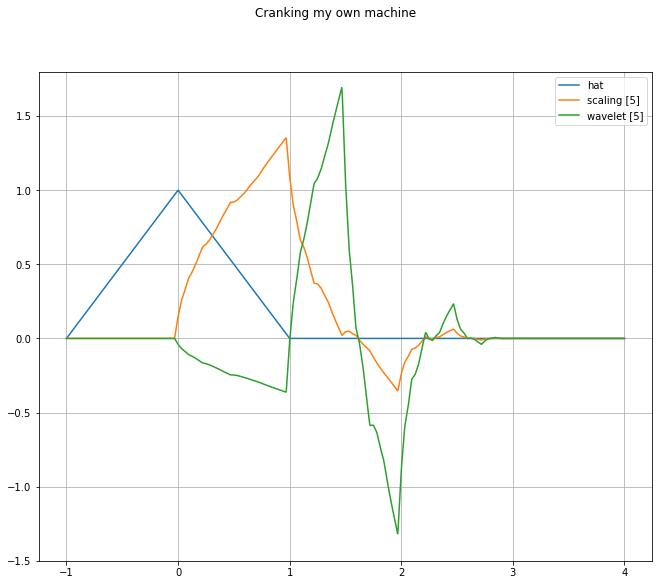

In [10]:
ScalingFunction = HaarScalingFunction
ScalingFunction = Daubechies4ScalingFunction

a, b =  -1.0, 4.0
plotLevel  = 8
itermax = 5

fig = plt.figure(1, figsize = (11, 9))
plt.suptitle('Cranking my own machine')
_ = plt.grid(True)
_ = plt.ylim(-1.5, 1.8)

# starting point in the fixed point iteration
hat = lambda t: max(0.0, 1-abs(t))

# set of sampling points used for plotting
x = np.linspace(a, b, int(b-a) << plotLevel)

# plot the hat function
ax = []
ax.append(plt.plot(x, list(map(hat, x)), label="hat"))

# Output scaling functions (father)
fixedPointScaling = [hat,] + [None,]* itermax

# Output wavelet functions (mother)
fixedPointWavelet = [hat,] + [None,]* itermax

for i in range(1, itermax + 1):
    fixedPointScaling[i] = FixedPointScalingApproximation(fixedPointScaling[i-1], ScalingFunction.c)
    fixedPointWavelet[i] = FixedPointWaveletApproximation(fixedPointScaling[i-1], ScalingFunction.c)    


ax.append(plt.plot(x, list(map(fixedPointScaling[itermax], x)), label="scaling [%d]" % itermax))
ax.append(plt.plot(x, list(map(fixedPointWavelet[itermax], x)), label="wavelet [%d]" % itermax))

_ = plt.legend()
_ = plt.show()



# Exercise 2: The Haar Wavelet Basis Transform #

In this exercise we want to compute the 1-$d$ wavelet transform for the Haar wavelet family and apply it to a signal vector $\vec{s}$ of length $m=2^n$.<br/>
The transform can be implemented very efficiently as a ``pyramidal algorithm'' taking $\mathcal{O}(m)$ steps.<br/>
For educational purpose we focus on the $\mathcal{O}(m^2)$ matrix-based algorithm.

In [11]:
def buildHaarWaveletTransformationMatrix(level, inverse=False):
    '''
    Haar Wavelet Transform as dense matrix

    @param level matrix dimensions are (2^level x 2^level)
    @param normalized build orthogonal matrix
    @param inverse build the inverse transformation matrix
    '''
    M = np.zeros((2**level,2**level))

    for i in range(2**level):
        M[i,0] = 1
    j = 1
    for l in range(1,level+1):
        for j_level in range(2**(l-1)):
            delta = 2**(level - l)
            start = 2 * delta * j_level
            end = start + delta
            for i in range(start,end):
                M[i,j] = 1
            for i in range(start+delta,end+delta):
                M[i,j] = -1
            j += 1
    
    if inverse:
        return np.linalg.inv(M)
    return M

In [12]:
M = buildHaarWaveletTransformationMatrix(3, False)
M_inv = buildHaarWaveletTransformationMatrix(3, True)
print(M)
print(M_inv)

[[ 1.  1.  1.  0.  1.  0.  0.  0.]
 [ 1.  1.  1.  0. -1.  0.  0.  0.]
 [ 1.  1. -1.  0.  0.  1.  0.  0.]
 [ 1.  1. -1.  0.  0. -1.  0.  0.]
 [ 1. -1.  0.  1.  0.  0.  1.  0.]
 [ 1. -1.  0.  1.  0.  0. -1.  0.]
 [ 1. -1.  0. -1.  0.  0.  0.  1.]
 [ 1. -1.  0. -1.  0.  0.  0. -1.]]
[[ 0.125  0.125  0.125  0.125  0.125  0.125  0.125  0.125]
 [ 0.125  0.125  0.125  0.125 -0.125 -0.125 -0.125 -0.125]
 [ 0.25   0.25  -0.25  -0.25  -0.    -0.    -0.    -0.   ]
 [-0.    -0.    -0.    -0.     0.25   0.25  -0.25  -0.25 ]
 [ 0.5   -0.5   -0.    -0.    -0.    -0.    -0.    -0.   ]
 [-0.    -0.     0.5   -0.5   -0.    -0.    -0.    -0.   ]
 [-0.    -0.    -0.    -0.     0.5   -0.5   -0.    -0.   ]
 [-0.    -0.    -0.    -0.    -0.    -0.     0.5   -0.5  ]]


In [6]:
# Input signal vector
s = np.array([1.0, 2.0, 3.0, -1.0, 1.0, -4.0, -2.0, 4.0])
print('Input signal: ',s)

d = np.array(np.dot(M_inv,s.transpose()))
print('Result from Matrix transformation: ',d)

ss = np.array(np.dot(M, d.transpose()))
print('Resutl from reversed Matrix transforamtion: ',ss.transpose())


Input signal:  [ 1.  2.  3. -1.  1. -4. -2.  4.]
Result from Matrix transformation:  [ 0.5   0.75  0.25 -1.25 -0.5   2.    2.5  -3.  ]
Resutl from reversed Matrix transforamtion:  [ 1.  2.  3. -1.  1. -4. -2.  4.]
